# Library imports

In [74]:
import rasterio
from rasterio.windows import Window

import matplotlib.pyplot as plt
import matplotlib.colors

import numpy as np

%matplotlib notebook

# Loading the data

In [2]:
dataset_filename = '../DATA/Flight_01-08_OrthoVIS16_/OrthoVIS16.tif'
# dataset_filename = '/Users/vasilii.mosin/Desktop/HYPERSPECTRAL_DATA/Flight_01-08_OrthoVIS16_/OrthoVIS16.tif'

In [3]:
dataset = rasterio.open(dataset_filename)

In [4]:
bands = dataset.indexes[:-1]

# Inspecting the data 

In [8]:
print(f'The dataset {dataset.name} is a {dataset.width}x{dataset.height} image containing {len(bands)} bands.')

The dataset ../DATA/Flight_01-08_OrthoVIS16_/OrthoVIS16.tif is a 7784x7954 image containing 17 bands.


In [9]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'uint16',
 2: 'uint16',
 3: 'uint16',
 4: 'uint16',
 5: 'uint16',
 6: 'uint16',
 7: 'uint16',
 8: 'uint16',
 9: 'uint16',
 10: 'uint16',
 11: 'uint16',
 12: 'uint16',
 13: 'uint16',
 14: 'uint16',
 15: 'uint16',
 16: 'uint16',
 17: 'uint16',
 18: 'uint16'}

In [136]:
dataset.bounds

BoundingBox(left=45.4419705219378, bottom=61.42842706873281, right=45.485734695600044, top=61.449840180541)

In [137]:
dataset.crs

CRS({'init': 'epsg:4326'})

In [138]:
cm = matplotlib.colors.Colormap('inferno', N=256)
cm=plt.get_cmap('viridis')
cm.set_bad(color='k')

In [139]:
print(cm)

<IPython.core.display.Javascript object>


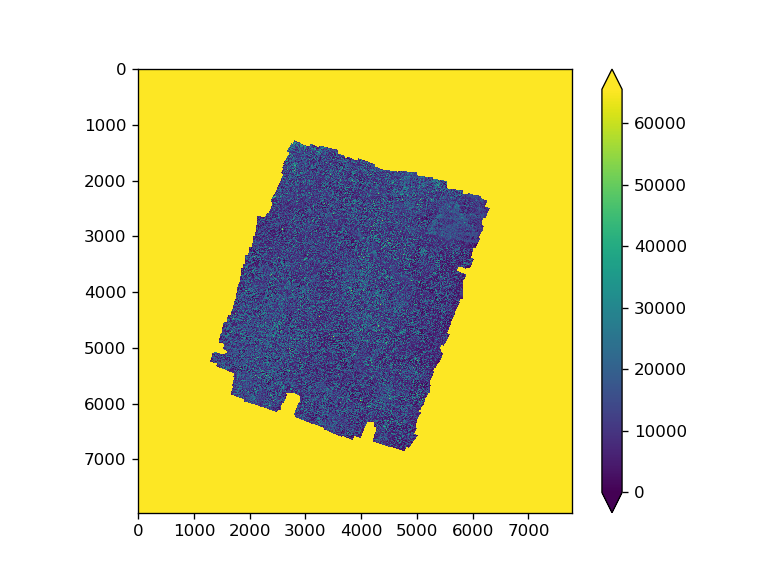

In [140]:
band1 = dataset.read(1)

plt.figure()
plt.imshow(band1,cmap=plt.cm.viridis)
plt.colorbar(extend='both')
#plt.clim(0, 50000);

## Dataset mask

The last channel (# 18) is the image mask that identifies regions of valid data values. 

<IPython.core.display.Javascript object>


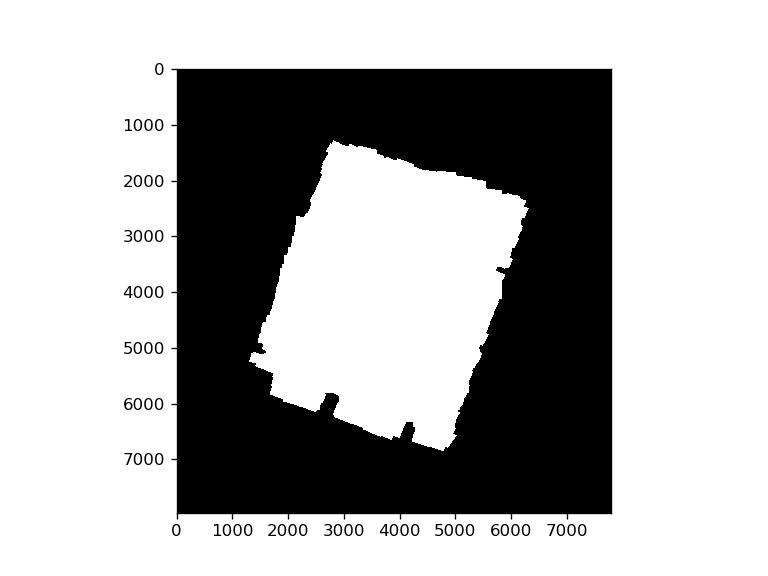

In [217]:
band16 = dataset.read(18)

plt.figure()
plt.imshow(band16,cmap=plt.cm.binary_r)

#  ITCD - Individual tree crown detection

## Load a window from the whole dataset

In [5]:
from thresholding_watershed import itcd as itcd_tw
#from local_maxima import itcd as itcd_lm
from skimage.color import gray2rgb

from skimage.exposure import rescale_intensity

In [26]:
with rasterio.open(dataset_filename) as src:
...     trees = src.read(src.indexes, window=Window(3080, 2090, 256, 256))[:-1]

In [27]:
trees_mono = trees[selected_band]

<IPython.core.display.Javascript object>


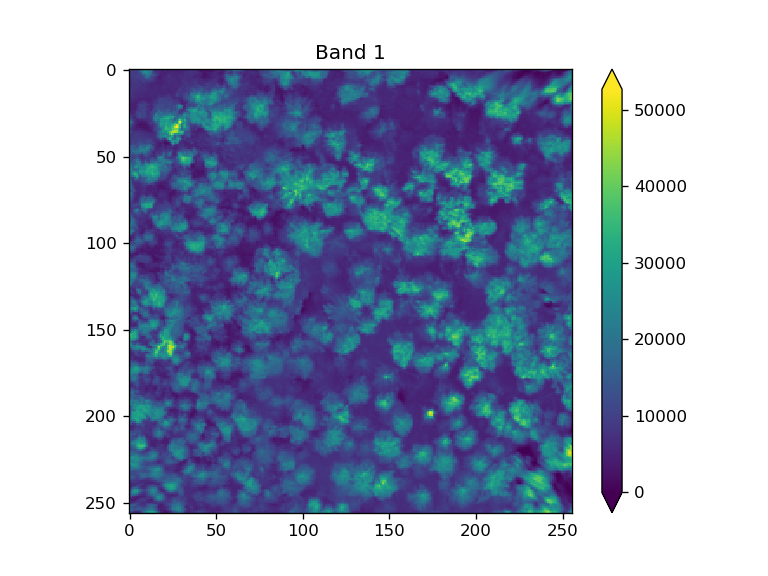

In [28]:
plt.figure()
plt.title(f'Band 1')
plt.imshow(trees_mono)
plt.colorbar(extend='both')

## Watershed ITCD

In [29]:
from rasterio.mask import mask
from shapely.affinity import translate,affine_transform
from shapely.geometry import mapping

In [30]:
selected_band = 0

trees_mono = trees[selected_band]

# Scale image
trees_mono_n = rescale_intensity(trees_mono,out_range='uint8')

<IPython.core.display.Javascript object>


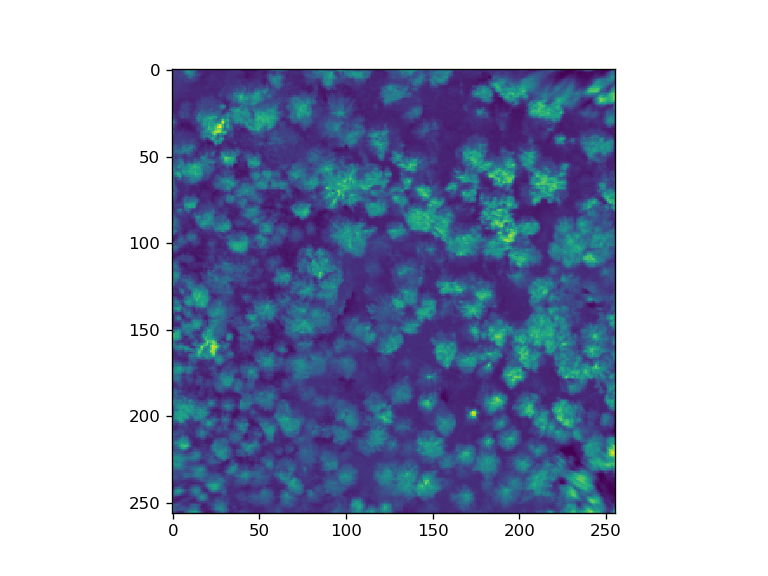

In [31]:
plt.figure()
plt.imshow(trees_mono_n)

<IPython.core.display.Javascript object>


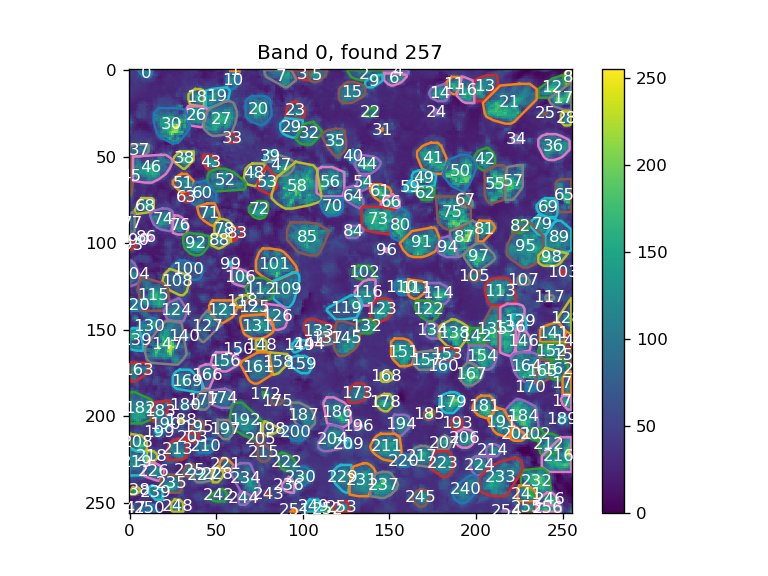

In [71]:
# Compute ITCD
polys = itcd_tw(trees_mono_n, smoothing=2, rgb=False, n_dilation=0)

plt.figure()
plt.imshow(trees_mono_n)
plt.title(f'Band {selected_band}, found {len(polys)}')
plt.colorbar()
# Plot
for n, pol in enumerate(polys):
    x,y = pol.exterior.xy if pol.geom_type == 'Polygon' else pol.coords
    plt.plot(x,y)
    xc,yc = pol.centroid.xy
    plt.text(xc[0],yc[0],n,ha="center", va="center", color="w",size=10)

### Save polygons to a shape-file with geo coordinates

In [72]:
import fiona
from shapely.geometry import MultiPolygon

shape_file = '../test_shape/my_shp3.shp'

In [73]:
affine_matrix = [dataset.transform.a,
                 dataset.transform.b,
                 dataset.transform.d,
                 dataset.transform.e,
                 dataset.transform.c,
                 dataset.transform.f]

polys_t = translate(polys,xoff=3080,yoff=2090)

polys_tt = affine_transform(polys_t,affine_matrix)

schema = {'geometry': 'Polygon', 'properties': {'id': 'int'},}

with fiona.open(shape_file, 'w', 'ESRI Shapefile', schema, dataset.crs) as c:
    for i, poly_tt in enumerate(polys_tt):
        c.write({'geometry': mapping(poly_tt),'properties': {'id': i},})

## Local Maxima ITCD

In [16]:
i = 7

trees_mono = trees[i,:]

# Scale image
trees_mono_n = rescale_intensity(trees_mono,out_range='uint8')

<IPython.core.display.Javascript object>


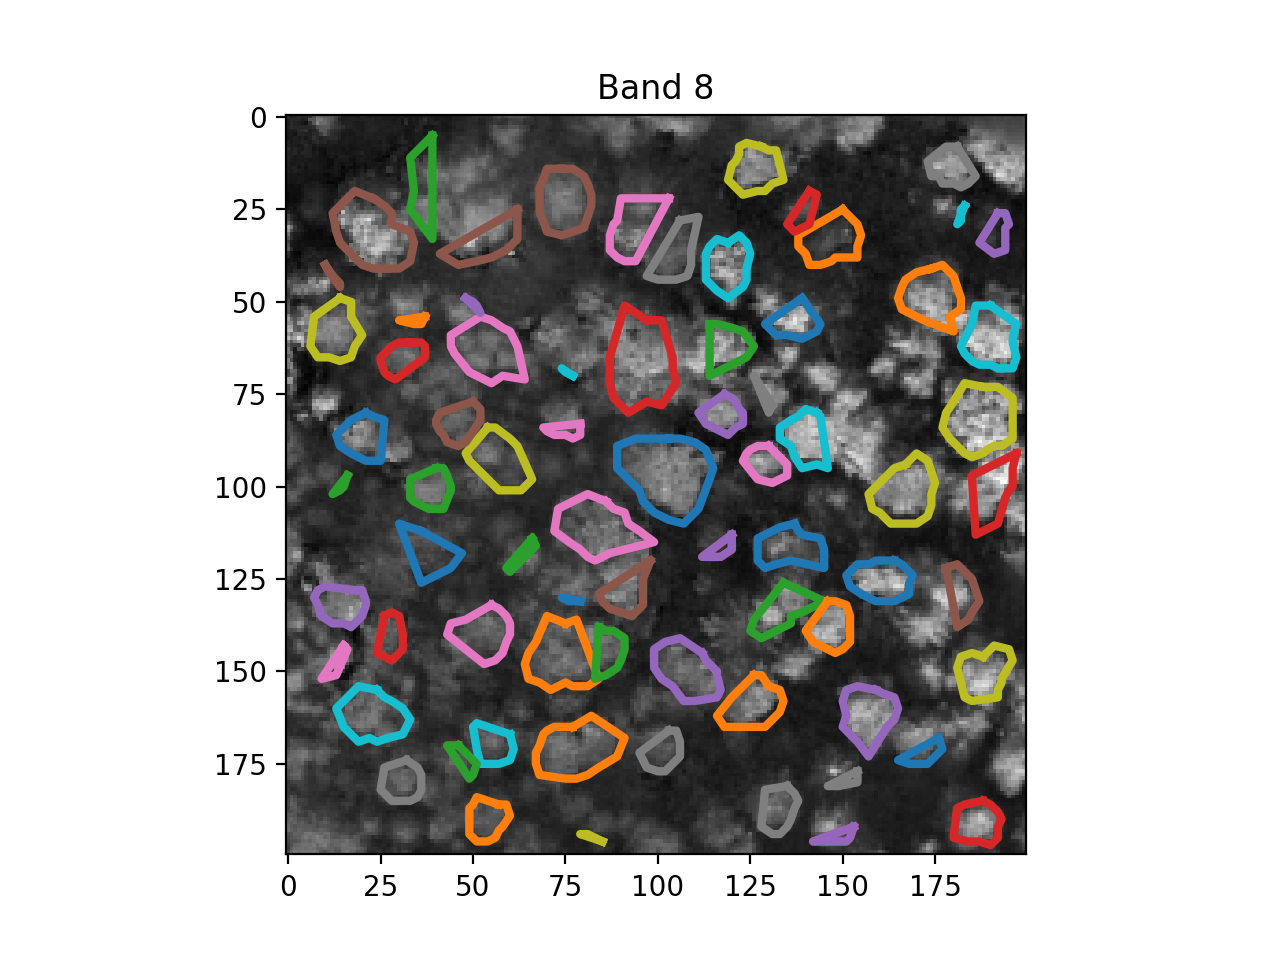

Text(0.5, 1.0, 'Band 8')

In [17]:
i = 7

trees_mono = trees[i,:]

# Scale image
trees_mono_n = rescale_intensity(trees_mono,out_range='uint8')

# Compute ITCD
crowns_lm = itcd_lm(trees_mono_n, smoothing=3, rgb=False, min_crown=5, max_crown=40, fitting=0.99, 
                    sharpness=100,
                    n_transects=16,
                    outliers=2)

# Plot
crowns_map = gray2rgb(trees_mono_n)
plt.figure()
plt.imshow(crowns_map)
for crown in crowns_lm:
    plt.plot(crown[:,0], crown[:,1], linewidth=3)
    
plt.title(f'Band {bands[i]}')

Running it on other bands.

In [34]:
fig, axes = plt.subplots(4,5,sharex=True,sharey=True)

for i, trees_mono in enumerate(trees):

    # Scale image
    trees_mono_n = rescale_intensity(trees_mono,out_range='uint8')

    # Compute ITCD
    crowns_lm = itcd_lm(trees_mono_n, smoothing=2, rgb=False, min_crown=10, max_crown=300, fitting=0.99, sharpness=100)

    # Plot
    crowns_map = gray2rgb(trees_mono_n)    
    axes.flatten()[i].imshow(crowns_map)
    for crown in crowns_lm:
        axes.flatten()[i].plot(crown[:,0], crown[:,1], linewidth=3)
    axes.flatten()[i].set_title(f'Band {bands[i]}')

<IPython.core.display.Javascript object>

/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_divide
  return np.degrees(np.arccos(numer / denom))
/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_divide
  return np.degrees(np.arccos(numer / denom))
/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_divide
  return np.degrees(np.arccos(numer / denom))
/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_divide
  return np.degrees(np.arccos(numer / denom))
/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_divide
  return np.degrees(np.arccos(numer / denom))
/home/guillermo/Works/Skoltech/forest-inventory-ml/local_maxima.py:106: RuntimeWarning: invalid value encountered in true_div

KeyboardInterrupt: 

### Writing Results to a Shapefile

In [25]:
from to_shapefile import crowns_points, crowns_polygons

In [30]:
shape_file = '../test_shape/my_shp0.shp'

In [31]:
!touch $shape_file

In [ ]:
from skimage import io, img_as_uint

io.use_plugin('freeimage')

im = img_as_uint(tree_mono)

io.imsave('tree_mono.png', im)
im2 = io.imread('tree_mono.png')

In [33]:
crowns_points(shape_file, crowns_tw, dataset, row_shift=2090, col_shift=3080)

In [20]:
crowns_polygons('test_shape/my_shp1.shp', crowns_lm, dataset, row_shift=2090, col_shift=3080)

# Individual tree exploration

## Extract individual trees identified

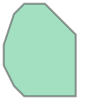

In [125]:
polygon_number = 10

pol_tt = polys_tt[polygon_number]
pol_t = polys_t[polygon_number]
pol = polys[polygon_number]
pol_t

In [215]:
tree, tree_transform = mask(dataset,[mapping(pol_tt)],crop=True,all_touched=True,filled=False,invert=False)

<IPython.core.display.Javascript object>


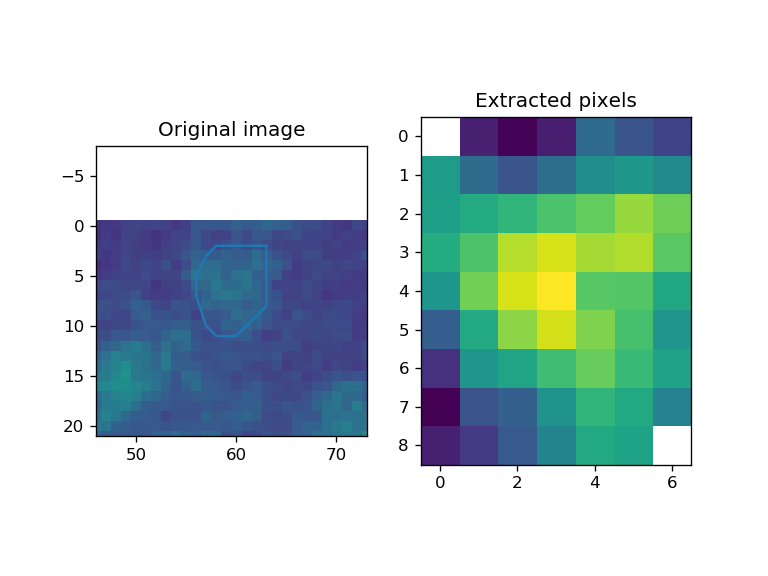

(46.0, 73.0)

In [290]:
fig, ax = plt.subplots(1,2)

ax[1].set_title("Extracted pixels")
ax[1].imshow(rescale_intensity(tree[selected_band],out_range='uint8'))

ax[0].set_title("Original image")
ax[0].imshow(trees_mono_n)#[0:5+int(y1),0:5+int(x1)])
x,y = pol.exterior.xy if pol.geom_type == 'Polygon' else pol.coords
ax[0].plot(x,y)
ax[0].set_ylim((10+y1,-10+y0,))
ax[0].set_xlim((-10+x0,10+x1))

In [185]:
tree.shape

(18, 9, 7)

Running it on other bands.

<IPython.core.display.Javascript object>


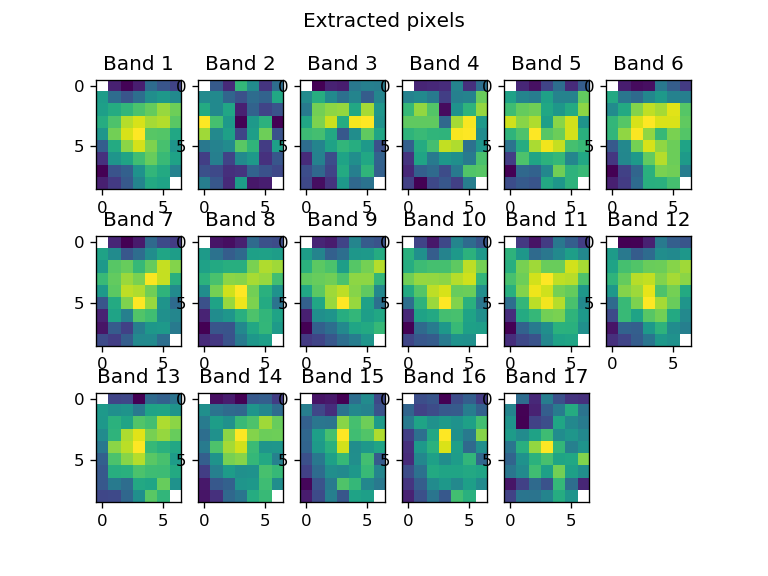

<IPython.core.display.Javascript object>


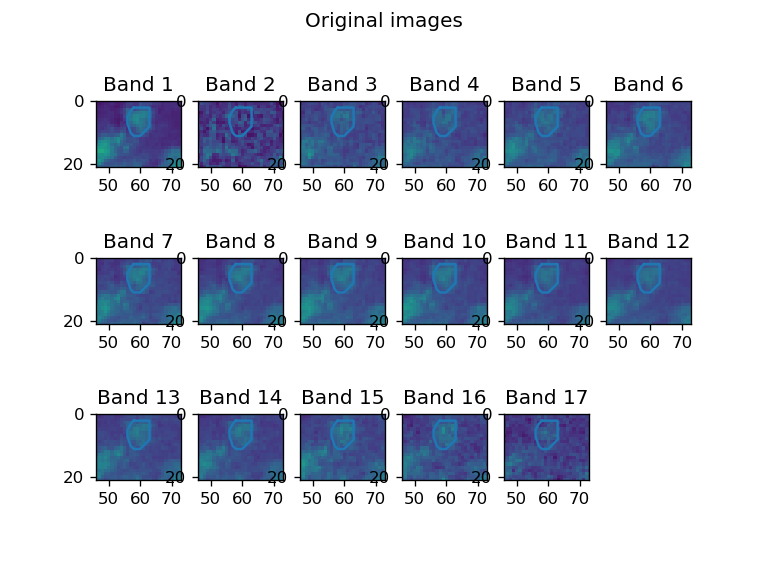

In [310]:
fig, ax = plt.subplots(3,len(bands)//3+1,squeeze=True)
fig.delaxes(ax.flatten()[-1])
fig.suptitle("Extracted pixels")
for i, band in enumerate(bands):    

    ax.flatten()[i].set_title(f'Band {band}')
    ax.flatten()[i].imshow(rescale_intensity(tree[band-1],out_range='uint8'))
    


    
    
    
fig, ax = plt.subplots(3,len(bands)//3+1,squeeze=True)
fig.delaxes(ax.flatten()[-1])
fig.suptitle("Original images")
for i, band in enumerate(bands):
    
    # Scale image
    trees_mono_n = rescale_intensity(trees[band-1],out_range='uint8')

    ax.flatten()[i].set_title(f'Band {band}')
    ax.flatten()[i].imshow(trees_mono_n)#[0:5+int(y1),0:5+int(x1)])
    x,y = pol.exterior.xy if pol.geom_type == 'Polygon' else pol.coords
    ax.flatten()[i].plot(x,y)
    ax.flatten()[i].set_ylim((10+y1,max(0,-10+y0)))
    ax.flatten()[i].set_xlim((max(0,-10+x0),10+x1))

## Display all bands

<IPython.core.display.Javascript object>


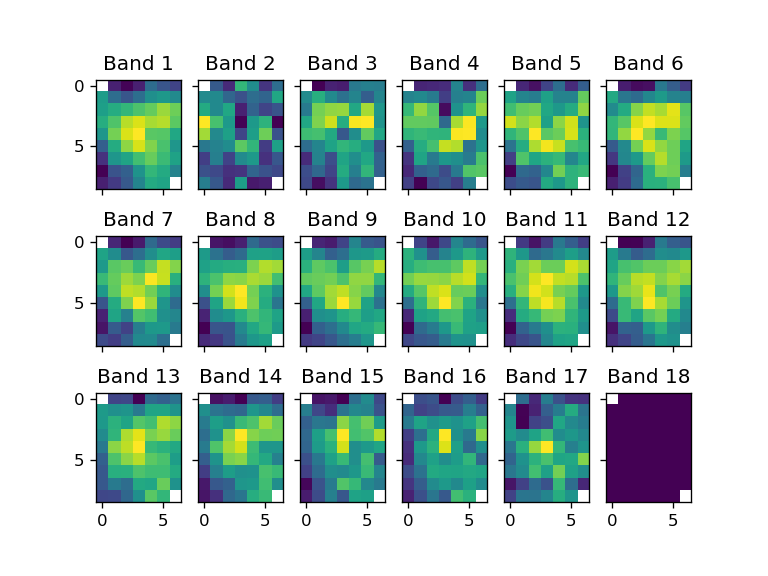

In [226]:
fig, axes = plt.subplots(3,6,sharex=True,sharey=True)
for i in range(len(dataset.indexes)):
    axes.flatten()[i].imshow(tree[i,:,:])
    axes.flatten()[i].set_title(f'Band {dataset.indexes[i]}')

## Hyperspectral features extraction

In [224]:
tree_p_b = tree.reshape(tree.shape[0],-1)[:-1]

tree_avg = np.ma.average(tree_p_b,axis=1)
tree_min = np.ma.min(tree_p_b,axis=1)
tree_max = np.ma.max(tree_p_b,axis=1)

<IPython.core.display.Javascript object>


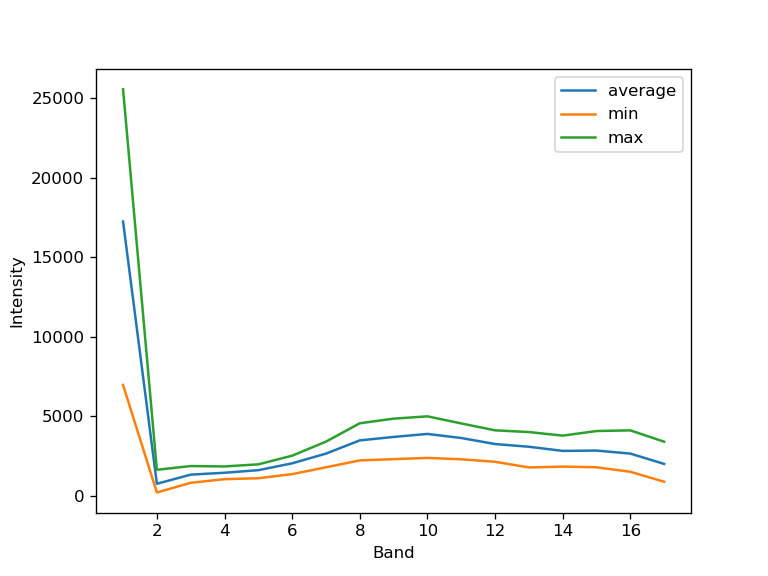

In [311]:
plt.figure()
plt.plot(bands,tree_avg, label = 'average')
plt.plot(bands,tree_min, label = 'min')
plt.plot(bands,tree_max, label = 'max')

plt.xlabel("Band")
plt.ylabel("Intensity")
plt.legend()

## Hyperspectral feature extraction for all trees

In [315]:
features.shape

(257, 51)

In [317]:
features = np.zeros((len(polys),17*3))

for i, pol_tt in enumerate(polys_tt):
    tree, tree_transform = mask(dataset,[mapping(pol_tt)],crop=True,all_touched=True,filled=False,invert=False)
    
    tree_p_b = tree.reshape(tree.shape[0],-1)[:-1]

    tree_avg = np.ma.average(tree_p_b,axis=1)
    tree_min = np.ma.min(tree_p_b,axis=1)
    tree_max = np.ma.max(tree_p_b,axis=1)
    
    features[i,:] = np.hstack((tree_avg,tree_min,tree_max))

In [322]:
import pandas as pd

features_pd = pd.DataFrame(features)

features_pd.to_csv("../features/features.csv")

## Bonus: plot animation

In [275]:
import matplotlib.colors as colors

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)
    ax.set_title(f'Band {ax.index+1}')

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])
    ax.set_title(f'Band {ax.index+1}')

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    ax.set_title(f'Band {ax.index+1}')

<IPython.core.display.Javascript object>


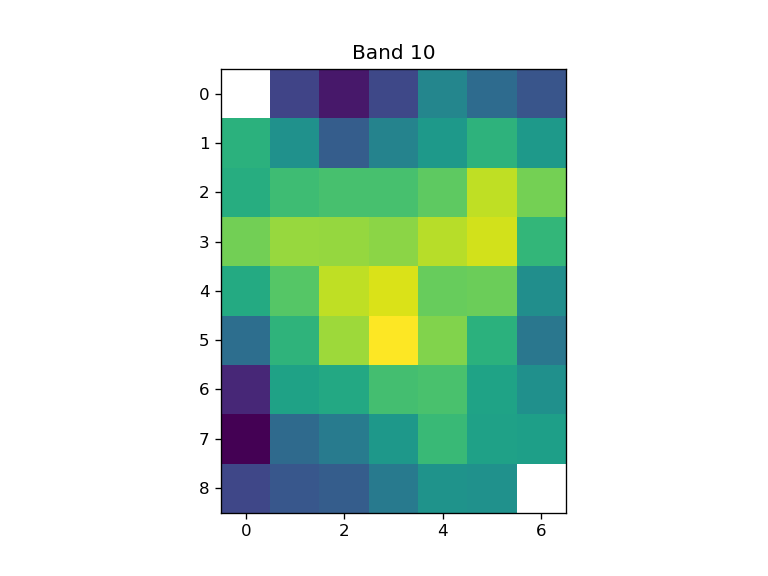

In [276]:
multi_slice_viewer(tree)

In [266]:
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


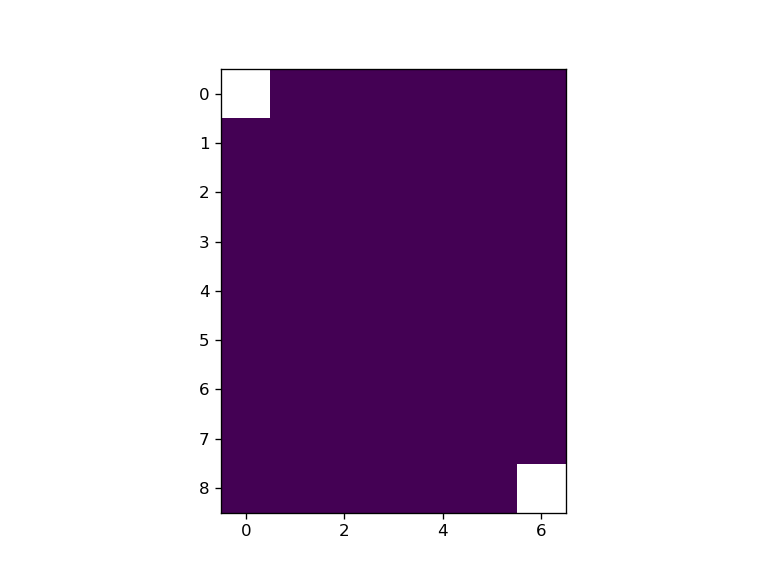

In [288]:
fig = plt.figure()
im = plt.imshow(tree[0])
 
    
def animate(i):
    im.set_array(tree[i])
    return im,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=18, interval=300, blit=True)
plt.show()